# Setting

In [77]:
import numpy as np
from scipy import stats, special
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from matplotlib import pyplot as plt

import pymc3 as pm
import math

import os
import arviz as az

In [2]:
def print_machine_type(thold_cpu=None, thold_mem=None):
    """ system info """
    cpu_count = os.cpu_count()
    tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])
    mem_gb = round(tot_m/1024)
    print(f'{cpu_count} vCPUs, {mem_gb} GB RAM')
    for name, val, thold in [['cpu', cpu_count, thold_cpu],['mem', mem_gb, thold_mem]]:
        if thold is not None:
            if val < thold:
                print(f'{name} {val} less than the threshold {thold}')
    return (cpu_count, mem_gb)

In [3]:
def print_interval(low, high, text='confidence interval: '):
    #low, high = low*100, high*100
    p = (low+high)/2
    err = high - p
    #print(f'{text}{p:.3f} ± {err:.4f}, [{low:.3f}, {high:.3f}]')
    print(f'{text}{p} ± {err}, [{low}, {high}]')

# Data

- https://prolotto.tistory.com/entry/%EB%A1%9C%EB%98%90-%EB%93%B1%EC%88%98%EB%B3%84-%EB%8B%B9%EC%B2%A8%ED%99%95%EB%A5%A0-%EA%B3%84%EC%82%B0-%EA%B3%A0%EC%A0%95%EC%88%98x-%EC%A0%9C%EC%99%B8%EC%88%98x
- https://namu.wiki/w/%EB%A1%9C%EB%98%90%206/45#rfn-57

## 등수별 당첨확률

In [4]:
# 1등 당첨 확률
N = 45
k = 6
n_all = special.comb(N, k)
n1 = special.comb(k, k)
p1 = n1/n_all
n1, round(1/p1), p1

(1.0, 8145060, 1.2277380399898834e-07)

In [5]:
# 1등 당첨 확률: 개별 숫자의 확률로부터 계산
N = 45
n = 6
k = 6

p_n = [1/N]*n
p_n_t = p_n

for i in range(1,k):
    p_n_t[i:] = [x/(1-p_n_t[i-1]) for x in p_n_t[i:]]
    
special.perm(n,n) * math.prod(p_n_t)

1.2277380399898837e-07

In [6]:
# 2등 당첨 확률
N = 45
k = 6
k2 = 5
n2 = special.comb(k, k2)*special.comb(k-k2,1)*special.comb(N-k-1, 0)
p2 = n2/n_all
n2, round(1/p2), p2

(6.0, 1357510, 7.3664282399393e-07)

In [7]:
p2, n2*p1

(7.3664282399393e-07, 7.3664282399393e-07)

In [8]:
# 3등 당첨 확률
N = 45
k = 6
k3 = 5
n3 = special.comb(k, k3)*special.comb(k-k3,0)*special.comb(N-k-1, 1)
p3 = n3/n_all
n3, round(1/p3), p3

(228.0, 35724, 2.7992427311769342e-05)

In [9]:
# 4등 당첨 확률
N = 45
k = 6
k4 = 4
n4 = special.comb(k, k4)*special.comb(N-k, k-k4)
p4 = n4/n_all
n4, round(1/p4), p4

(11115.0, 733, 0.0013646308314487555)

In [10]:
# 5등 당첨 확률
N = 45
k = 6
k5 = 3
n5 = special.comb(k, k5)*special.comb(N-k, k-k5)
p5 = n5/n_all
n5, round(1/p5), p5

(182780.0, 45, 0.02244059589493509)

- 2004년 8월 1일부터 규정을 변경, 게임당 2,000원에서 1,000원으로 가격을 내리고 이월 횟수도 2회로 줄이면서 평균 당첨 금액도 10억 중반 대로 상당히 줄어들었다.
- 최초에는 4등 당첨금도 배당률에 의해 유동적이었으나 당첨금이 과세기준인 5만 원을 넘을 경우, 배당률이 높은데 수령금은 더 적어지는 문제가 있어 2010년 8월부터 5만 원 정액으로 바뀌었다. 그 후 당첨금을 판매점에서 지급하게 되었다.
- 1등의 당첨금 배분 비율: 총 당첨금 중 4등과 5등 금액을 제외한 금액의 75%
- 총 당첨금은 로또 전체 판매액의 50%이며, 42% 이상은 복권기금으로 활용됩니다.

In [11]:
def get_sold(prize, winner, price=1000, r1=.75, r2=.5, total=0):
    """
    price: list of money for 1,2,3,4,5th prize
    winner: list of number of winner from 1 to 5th prize
    """
    n_sold = prize[0]*winner[0]/r1 + sum([x*y for x,y in zip(prize[-2:],winner[-2:])])
    n_sold = round(n_sold/r2/price)
    print(f'number of sold: {n_sold:.5e}')
    if total > 0:
        n = int(total/price) # number of tickets sold
        print(f'number of sold (check): {n:.5e}')
    return n_sold

# 1057회차

In [12]:
# 1057회차
prize = [1616069714, 6895880, 1545870, 50000, 5000]
winner = [17, 664, 2962, 146471, 2461496]
n_sold = get_sold(prize, winner, total=112523887000)

number of sold: 1.12524e+08
number of sold (check): 1.12524e+08


## 1등
1등 당첨자의 수는 가능한 범위내

In [24]:
# Test for proportions based on normal (z) test

n = n_sold
k = winner[0]
p = p1

stat, pval = proportions_ztest(k, n, p)
stat, pval

(0.7724795050272403, 0.4398304809801675)

## 2등

### Hypothesis test 1
2등 당첨자의 수는 가능한 범위밖. 너무 많은 사람이 2등에 당첨.

In [25]:
n = n_sold
k = winner[1]
p = p2

stat, pval = proportions_ztest(k, n, p)
stat, pval

(22.5515114795004, 1.2977671934619935e-112)

### Hypothesis test 2 & interval 1

In [ ]:
n = n_sold
k = winner[1]
p = p2

result = stats.binomtest(k, n, p2)
result

BinomTestResult(k=664, n=112523887, alternative='two-sided', proportion_estimate=5.900969275972487e-06, pvalue=0.0)

In [ ]:
# the confidence interval of the estimate
result.proportion_ci(confidence_level=0.95)

ConfidenceInterval(low=5.460610458697295e-06, high=6.3673855429429066e-06)

### Interval 2

In [31]:
n = n_sold
k = winner[1]

alpha = 0.05
method = 'normal'
low, high = proportion_confint(k, n, alpha, method=method)
print(f'method = {method}')
print_interval(low, high)

method = normal
confidence interval: 5.900969275972487e-06 ± 4.4883438786293446e-07, [5.452134888109553e-06, 6.349803663835422e-06]


## Bayesian

### 1등

#### 당첨 확률

In [111]:
mu = p_ref = p1
obs = winner[0]
draws = n_sold
sigma = mu*1000

# 1 < sigma < sqrt(mu * (1 - mu))
sigma_max = np.sqrt(mu * (1 - mu)) # max of sigma
if sigma > sigma_max:
    print(f'WARNING: sigma ({sigma}) is gt max ({sigma_max})')

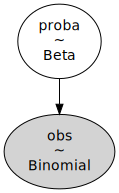

In [112]:
with pm.Model() as model:
    p = pm.Beta('proba', mu=mu, sigma=sigma)
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [113]:
n_tune, n_draws, n_chains = 2000, 1000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [proba]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 13 seconds.


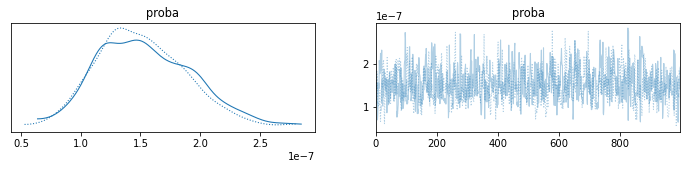

In [114]:
_ = az.plot_trace(trace)

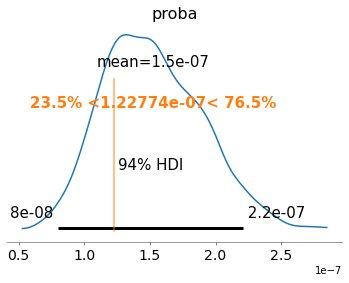

In [115]:
 _ = az.plot_posterior(trace, ref_val=p_ref)

##### Normal prior

In [26]:
mu = p_ref = p1
obs = winner[0]
draws = n_sold
#sigma = mu*100 # diverge
sigma = mu*1000 # diverge


# 1 < sigma < sqrt(mu * (1 - mu))
sigma_max = np.sqrt(mu * (1 - mu)) # max of sigma
if sigma > sigma_max:
    print(f'WARNING: sigma ({sigma}) is gt max ({sigma_max})')

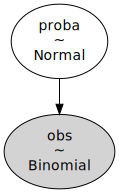

In [27]:
with pm.Model() as model:
    p = pm.Normal('proba', mu=mu, sigma=sigma)
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [28]:
n_tune, n_draws, n_chains = 2000, 1000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [proba]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 76 seconds.


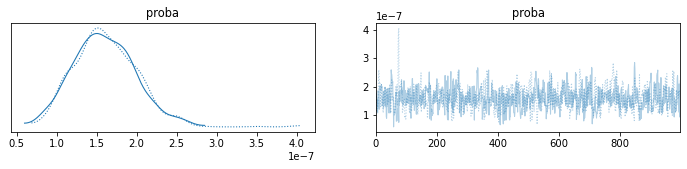

In [29]:
_ = az.plot_trace(trace)

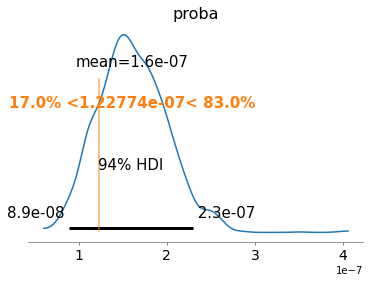

In [30]:
 _ = az.plot_posterior(trace, ref_val=p_ref)

#### 숫자 확률
1등 6개의 숫자 각각이 서로 다른 확률을 가진다고 할때, 1등 당첨자 수로 부터 각 숫자의 사후 확률 계산

In [13]:
mu = p_ref = 1/N
obs = winner[0]
draws = n_sold
sigma = mu*1

##### modeling 1

In [51]:
n = 6
p_n = [mu]*n

for i in range(1,n):
    p_n[i:] = [x/(1-p_n[i-1]) for x in p_n[i:]]

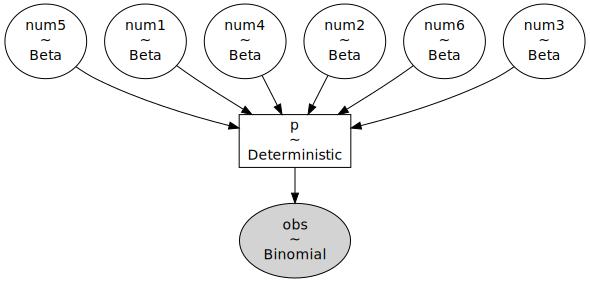

In [52]:
p_num = [None]*n
with pm.Model() as model:
    for i in range(n):
        p_num[i] = pm.Beta(f'num{i+1}', mu=p_n[i], sigma=sigma)
    p = pm.Deterministic('p', special.perm(n,n) * pm.math.prod(p_num))
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

##### modeling 2

In [46]:
n = 6
p_n = [mu]*n

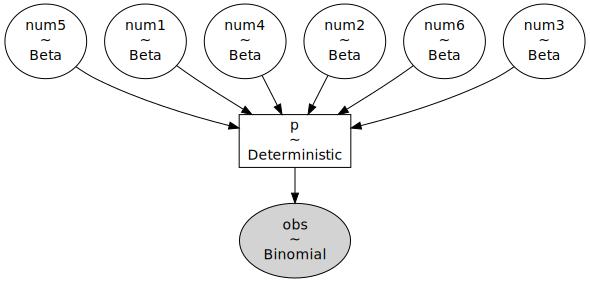

In [47]:
p_num = [None]*n
with pm.Model() as model:
    for i in range(n):
        p_num[i] = pm.Beta(f'num{i+1}', mu=p_n[i], sigma=sigma)
    p = [i*x/(1-x*(i-1)) for i, x in enumerate(p_num,1)]
    p = pm.Deterministic('p', pm.math.prod(p))
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [58]:
# TODO: implement. see https://cluhmann.github.io/inferencedata/

p_num = [None]*n
with pm.Model(coords={'nums': range(n)}) as model:
    p_num = pm.Beta(f'number', mu=p_n[0], sigma=sigma, dims='nums')
    p = [i*x/(1-x*(i-1)) for i, x in enumerate(p_num,1)]
    p = pm.Deterministic('p', pm.math.prod(p))
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

ValueError: Length of number ~ Beta cannot be determined

In [53]:
n_tune, n_draws, n_chains = 2000, 1000, None # 경향은 아래와 유사
#n_tune, n_draws, n_chains = 5000, 10000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [num6, num5, num4, num3, num2, num1]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 83 seconds.


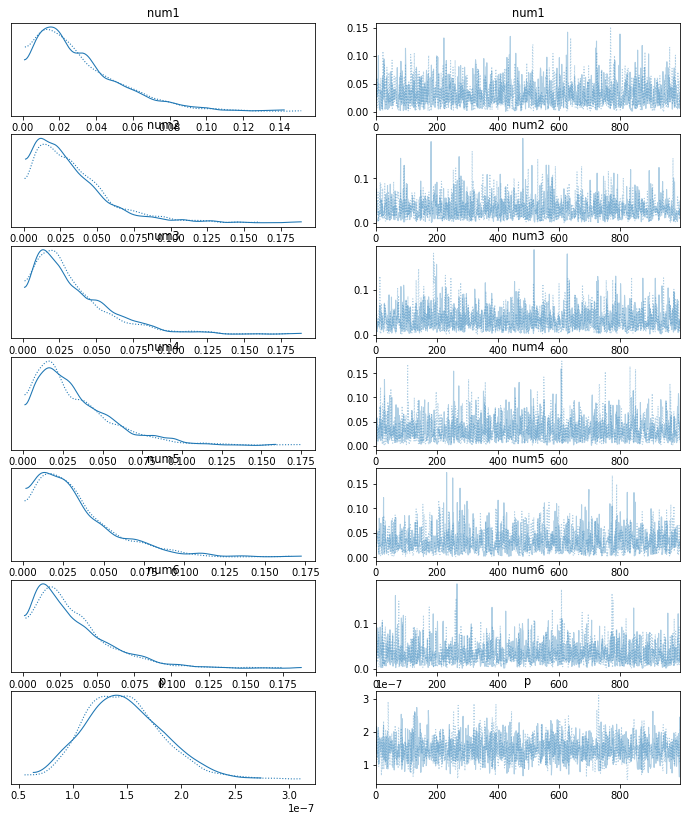

In [54]:
_ = az.plot_trace(trace)

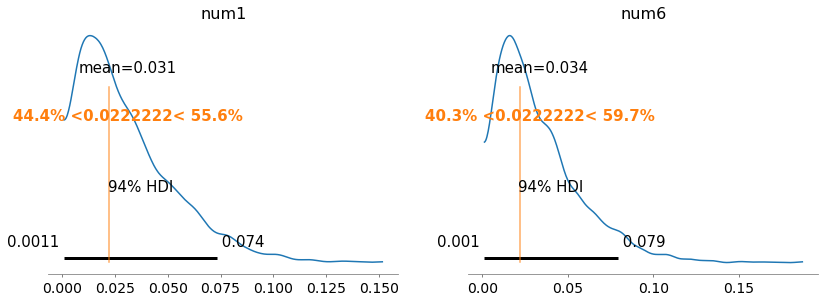

In [56]:
# modelling 1 result
#nums_to_plot = range(n)
#nums_to_plot = np.sort(np.random.choice(n, 2, replace=False))
nums_to_plot = [0,5]

_ = az.plot_posterior(trace, ref_val=p_ref, var_names=[f'num{i+1}' for i in nums_to_plot])

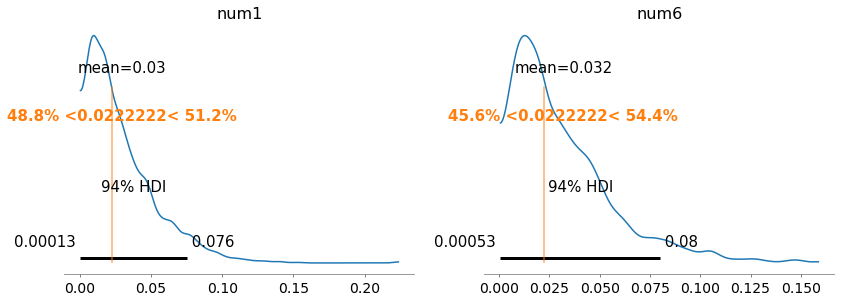

In [50]:
# modelling 2 result
#nums_to_plot = range(n)
nums_to_plot = np.sort(np.random.choice(n, 2, replace=False))

_ = az.plot_posterior(trace, ref_val=p_ref, var_names=[f'num{i+1}' for i in nums_to_plot])

### 2등

#### 당첨 확률

In [59]:
mu = p_ref = p2
obs = winner[1]
draws = n_sold
sigma = mu*1000

# 1 < sigma < sqrt(mu * (1 - mu))
sigma_max = np.sqrt(mu * (1 - mu)) # max of sigma
if sigma > sigma_max:
    print(f'WARNING: sigma ({sigma}) is gt max ({sigma_max})')

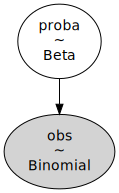

In [60]:
with pm.Model() as model:
    p = pm.Beta('proba', mu=mu, sigma=sigma)
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [61]:
n_tune, n_draws, n_chains = 2000, 1000, None
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [proba]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 14 seconds.


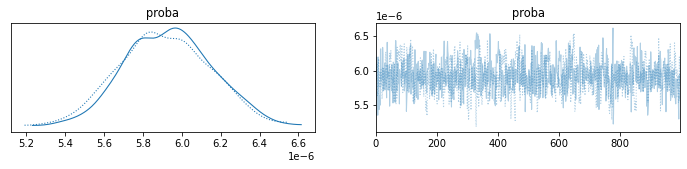

In [62]:
_ = az.plot_trace(trace)

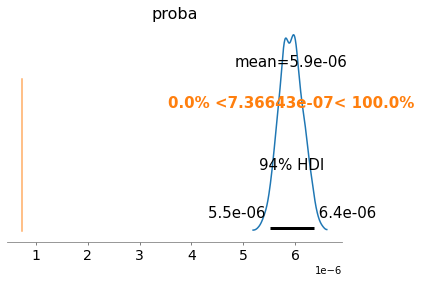

In [63]:
 _ = az.plot_posterior(trace, ref_val=p_ref)

In [64]:
p = 5.9e-6
print(f'{1/p2:e}, {1/p:e}')

1.357510e+06, 1.694915e+05


#### 숫자 확률

In [65]:
mu = p_ref = 1/N
obs = winner[1]
draws = n_sold
sigma = mu*1

In [66]:
n = 6
k = 5
p_n = [mu]*n

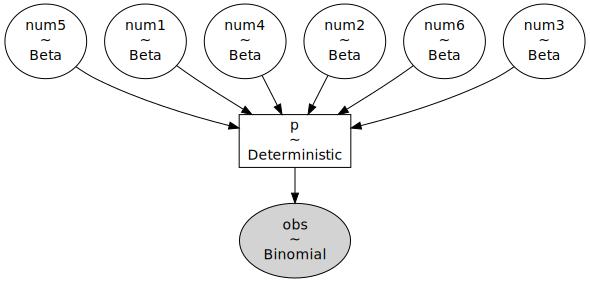

In [68]:
p_num = [None]*n
with pm.Model() as model:
    for i in range(n):
        p_num[i] = pm.Beta(f'num{i+1}', mu=p_n[i], sigma=sigma)
    p = [i*x/(1-x*(i-1)) for i, x in enumerate(p_num,1)]
    p = pm.Deterministic('p', special.comb(n, k) * pm.math.prod(p))
    p_post = pm.Binomial('obs', n=draws, p=p, observed=obs)
    
pm.model_to_graphviz(model=model)

In [85]:
#n_tune, n_draws, n_chains = 2000, 1000, None
n_tune, n_draws, n_chains = 5000, 10000, None # 시간은 엄청 오래 걸리는데 대세 변함 없음.
n_cpus, _ = print_machine_type()

with model:    
    trace = pm.sample(tune=n_tune, draws=n_draws, cores=n_cpus, chains=n_chains,
                      target_accept=0.95,
                      return_inferencedata=True)

2 vCPUs, 5 GB RAM


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [num6, num5, num4, num3, num2, num1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 3098 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


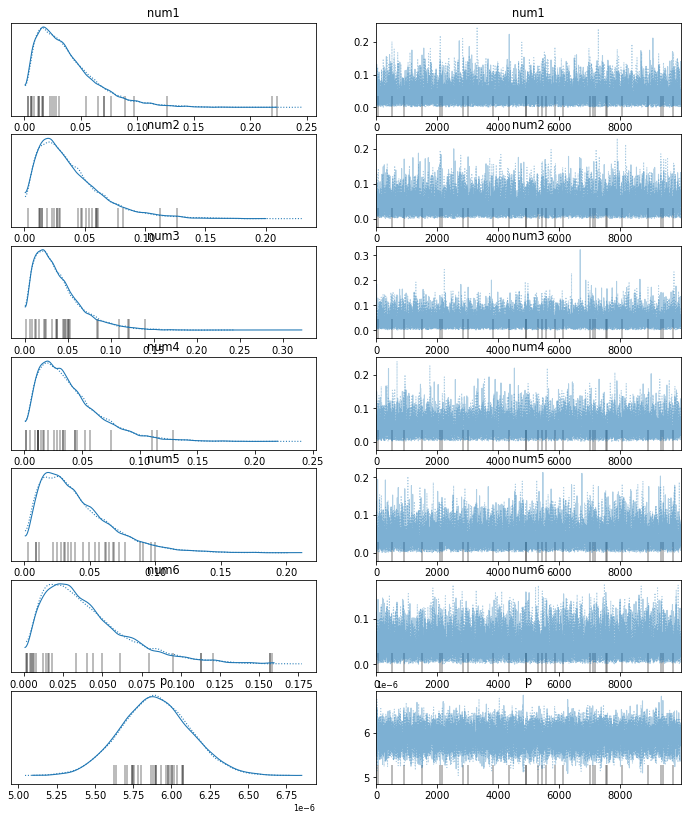

In [86]:
_ = az.plot_trace(trace)

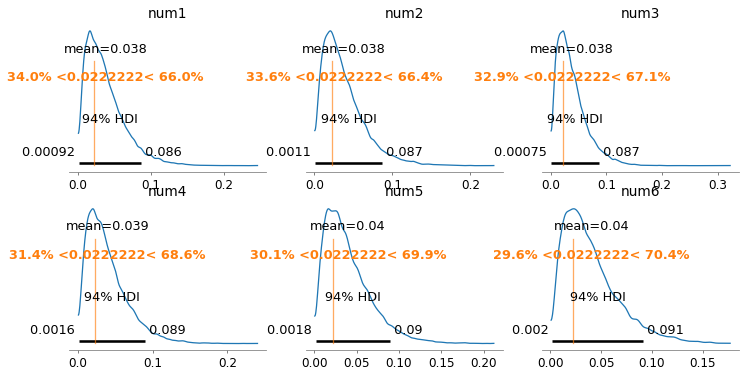

In [94]:
fig, ax = plt.subplots(2,3, figsize=(12,6))

nums_to_plot = range(n)
#nums_to_plot = np.sort(np.random.choice(n, 2, replace=False))

_ = az.plot_posterior(trace, ref_val=p_ref, var_names=[f'num{i+1}' for i in nums_to_plot], 
                      ax=ax,
                      textsize=12
                     )